In [18]:
import re
import random
import pandas as pd
import hashlib

In [19]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [20]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Azure AI Search,44.187057,3.156218,14
Taxes,480.839803,48.083980,10
PEP 8,569.089011,19.623759,29
Finance Junk,595.929294,74.491162,8
sklearn,617.561365,123.512273,5
WSL + Kali Linux,757.860611,22.290018,34
Open Source/GitHub,767.377088,33.364221,23
Python,913.696427,114.212053,8
PP365,973.384738,97.338474,10
AKS,1099.283252,137.410406,8


# Histogram

32513.90


<Axes: >

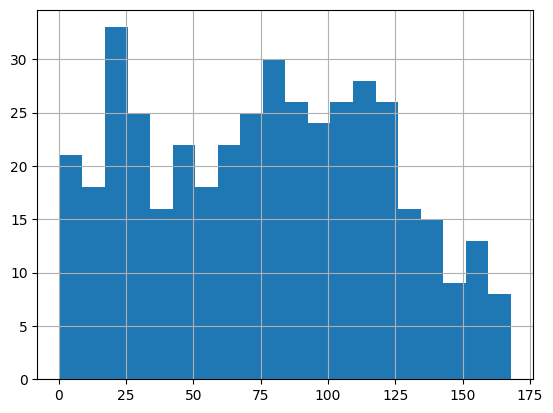

In [21]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [22]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [23]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# Headers with fewest notes first

In [24]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# Focus on one header

In [25]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [26]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [27]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Headers with greatest age sum first

In [28]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [29]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n
existing_cards['age'] *= -1
existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 421


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
68,AKS,Web App for Containers is a feature of Azure A...,0ea4528588243f329dcdef7f9539f2f5,-150.723268,137.410406,150.723268,1099.283252,0.007658,0,0
69,AKS,AKS is commonly used to host multiple workload...,a8907e00b222f8eef3d98d9ae88b3d4c,-137.511437,137.410406,150.723268,1099.283252,0.007658,3,0
70,AKS,AKS also provides access to the Kubernetes API...,5e4f81c408835ac7d21e06451a8d07b0,-132.559832,137.410406,150.723268,1099.283252,0.007658,6,0
118,IW Migration,SSMS Object Explorer\nA navigation pane in SQL...,a1b2fef670b3e30b615c84a63359c85d,-102.904520,85.442170,102.904520,2050.612068,0.011040,0,0
119,IW Migration,Macros (Access)\nAutomated actions or sequence...,8751921484b648337c5ab2315f65a3e1,-94.433219,85.442170,102.904520,2050.612068,0.011040,3,0
120,IW Migration,Forms (Access)\nUser-friendly interfaces for e...,b668285b9fd5fe65ab0229adb418cb78,-91.083901,85.442170,102.904520,2050.612068,0.011040,6,0
397,IW Migration,Template Explorer (SSMS)\nA feature in SQL Ser...,5b4f6badddb89919760ebc428cd9fb8d,-88.942592,85.442170,102.904520,2050.612068,0.011040,9,0
122,IW Migration,Linked Table Manager (in Access)\nA feature in...,5c59183063f46f48886078e49c5fa8ff,-87.670591,85.442170,102.904520,2050.612068,0.011040,12,0
123,IW Migration,Database Diagrams (SSMS)\nGraphical representa...,caf9c5ce7f5521a8a00e9d099914a6a7,-82.866372,85.442170,102.904520,2050.612068,0.011040,15,0
124,IW Migration,Property Sheets (Access)\nPanels that display ...,d9399e2ff0774171342b58e96e22e26f,-79.438840,85.442170,102.904520,2050.612068,0.011040,18,0


## Age Sum

In [30]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [31]:
# n=6
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [32]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)


In [33]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
68,AKS,Web App for Containers is a feature of Azure A...,0ea4528588243f329dcdef7f9539f2f5,-150.723268,137.410406,150.723268,1099.283252,0.007658,0,0
69,AKS,AKS is commonly used to host multiple workload...,a8907e00b222f8eef3d98d9ae88b3d4c,-137.511437,137.410406,150.723268,1099.283252,0.007658,3,0
70,AKS,AKS also provides access to the Kubernetes API...,5e4f81c408835ac7d21e06451a8d07b0,-132.559832,137.410406,150.723268,1099.283252,0.007658,6,0
118,IW Migration,SSMS Object Explorer\nA navigation pane in SQL...,a1b2fef670b3e30b615c84a63359c85d,-102.904520,85.442170,102.904520,2050.612068,0.011040,0,0
119,IW Migration,Macros (Access)\nAutomated actions or sequence...,8751921484b648337c5ab2315f65a3e1,-94.433219,85.442170,102.904520,2050.612068,0.011040,3,0
120,IW Migration,Forms (Access)\nUser-friendly interfaces for e...,b668285b9fd5fe65ab0229adb418cb78,-91.083901,85.442170,102.904520,2050.612068,0.011040,6,0
397,IW Migration,Template Explorer (SSMS)\nA feature in SQL Ser...,5b4f6badddb89919760ebc428cd9fb8d,-88.942592,85.442170,102.904520,2050.612068,0.011040,9,0
122,IW Migration,Linked Table Manager (in Access)\nA feature in...,5c59183063f46f48886078e49c5fa8ff,-87.670591,85.442170,102.904520,2050.612068,0.011040,12,0
123,IW Migration,Database Diagrams (SSMS)\nGraphical representa...,caf9c5ce7f5521a8a00e9d099914a6a7,-82.866372,85.442170,102.904520,2050.612068,0.011040,15,0
124,IW Migration,Property Sheets (Access)\nPanels that display ...,d9399e2ff0774171342b58e96e22e26f,-79.438840,85.442170,102.904520,2050.612068,0.011040,18,0


In [34]:
existing_cards.head(10)['age'].sum()

-1048.1345728102035